# Embedding Model

In [1]:
import matplotlib.pyplot as plt 
from matplotlib.lines import Line2D  # For custom legend markers
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Layer, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
import warnings # ignore warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../data/final_df_normalized.csv', sep='|') 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   account_id                              100000 non-null  object 
 1   yeojohnson_revenue_in_eur_bin           100000 non-null  float64
 2   is_EMEA                                 100000 non-null  int64  
 3   is_Webshop                              100000 non-null  int64  
 4   is_industry_FinanceInsuranceRealEstate  100000 non-null  int64  
 5   is_industry_Manufacturing               100000 non-null  int64  
 6   is_industry_Other                       100000 non-null  int64  
 7   is_industry_RetailTrade                 100000 non-null  int64  
 8   is_industry_Services                    100000 non-null  int64  
 9   is_industry_WholesaleTrade              100000 non-null  int64  
 10  license_value_score                     10000

In [4]:
df.head(10)

,account_id,yeojohnson_revenue_in_eur_bin,is_EMEA,is_Webshop,is_industry_FinanceInsuranceRealEstate,is_industry_Manufacturing,is_industry_Other,is_industry_RetailTrade,is_industry_Services,is_industry_WholesaleTrade,license_value_score,customer_value_score
0,ac6a99474410f1c59c91da3f0cf9cf3f,0.666667,0,1,0,0,0,0,1,0,0.225903,0.404288
1,1cc66628ed41f3db5a55195e93277a04,0.666667,0,1,0,0,0,0,0,1,0.692198,0.000000
2,db5f3cdd5629b9591b720b9b7e077df2,1.000000,0,1,0,0,0,0,1,0,0.025903,0.058008
3,bebb4028688f519f36ed220855b0a62f,1.000000,0,0,0,0,0,0,1,0,0.825945,0.703012
4,507c0bfb67895d773e3f8bd33b861d09,1.000000,0,0,1,0,0,0,0,0,0.826668,0.467596
5,b1267a5b953b7267de811510f838172b,0.666667,0,1,0,0,0,1,0,0,0.172568,0.270317
6,3315ad169d4d2e9080f1377c44377c7c,0.666667,0,0,0,0,0,0,1,0,0.784642,0.863665
7,8ca7b69eda1a06b32e60fff1c6db3b28,1.000000,0,0,0,0,1,0,0,0,0.530824,0.608520
8,5bd2eea4e2320b9246b41a8f54fb02d2,0.333333,0,0,0,0,0,0,1,0,0.925757,0.625388
9,bbfb03bca60fb0185be3f36d12c99b3f,0.666667,0,0,0,0,0,0,1,0,0.864130,0.635761


## Deep Embedding Clustering (DEC) Model

In [5]:
class ClusteringLayer(Layer):
    def __init__(self, n_clusters, **kwargs):
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters

    def build(self, input_shape):
        self.clusters = self.add_weight(name='clusters',
                                        shape=(self.n_clusters, input_shape[1]),
                                        initializer='glorot_uniform')

    def call(self, inputs, **kwargs):
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / 1.0))
        q = q ** ((1.0 + 1.0) / 2.0)
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
        return q

class DEC:
    def __init__(self, input_dim, encoding_dim, n_clusters, dropout_rate=0.2):
        self.input_dim = input_dim
        self.encoding_dim = encoding_dim
        self.n_clusters = n_clusters
        self.dropout_rate = dropout_rate
        self.autoencoder, self.encoder = self.build_autoencoder()
        self.model = self.build_dec_model()

    def build_autoencoder(self):
        input_layer = Input(shape=(self.input_dim,))
        encoder = Dense(64, activation='relu')(input_layer)
        encoder = Dropout(self.dropout_rate)(encoder)
        encoder = Dense(self.encoding_dim, activation='relu', kernel_initializer='glorot_uniform')(encoder)

        decoder = Dense(64, activation='relu', kernel_initializer='glorot_uniform')(encoder)
        decoder = Dropout(self.dropout_rate)(decoder)
        decoder = Dense(self.input_dim, activation='sigmoid', kernel_initializer='glorot_uniform')(decoder)

        autoencoder = Model(inputs=input_layer, outputs=decoder)
        autoencoder.compile(optimizer='adam', loss='mse')

        encoder_model = Model(inputs=input_layer, outputs=encoder)
        return autoencoder, encoder_model

    def build_dec_model(self):
        clustering_layer = ClusteringLayer(self.n_clusters, name='clustering')(self.encoder.output)
        model = Model(inputs=self.encoder.input, outputs=[clustering_layer, self.autoencoder.output])
        model.compile(optimizer='adam', loss=['kld', 'mse'])
        return model

    def pretrain_autoencoder(self, data, epochs=50, batch_size=256):
        early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
        with tf.device('/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'):
            self.autoencoder.fit(data, data, epochs=epochs, batch_size=batch_size, shuffle=True, callbacks=[early_stopping])

    def initialize_clusters(self, data):
        with tf.device('/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'):
            encoded_data = self.encoder.predict(data)
            kmeans = KMeans(n_clusters=self.n_clusters, n_init=20)
            kmeans.fit(encoded_data)
            initial_clusters = kmeans.cluster_centers_
            self.model.get_layer(name='clustering').set_weights([initial_clusters])

    def target_distribution(self, q):
        weight = q ** 2 / q.sum(0)
        return (weight.T / weight.sum(1)).T

    def train_dec(self, data, maxiter=8000, update_interval=140, tol=0.001):
        index = 0
        y_pred_last = None
        with tf.device('/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'):
            for ite in range(maxiter):
                if ite % update_interval == 0:
                    q, _ = self.model.predict(data, verbose=0)
                    p = self.target_distribution(q)

                    y_pred = q.argmax(1)
                    if ite > 0 and np.sum(y_pred != y_pred_last) / len(y_pred) < tol:
                        print('Reached tolerance threshold. Stopping training.')
                        break
                    y_pred_last = np.copy(y_pred)

                idx = index * update_interval % data.shape[0]
                loss = self.model.train_on_batch(x=data[idx:idx + update_interval],
                                                 y=[p[idx:idx + update_interval], data[idx:idx + update_interval]])
                index += 1
                print('Iteration', ite, 'Loss:', loss)

    def predict(self, data):
        with tf.device('/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'):
            q, _ = self.model.predict(data)
            return q.argmax(1)
        
    def summary(self):
        print("Auto Encoder Summary:")
        self.autoencoder.summary()
        print("DEC Model Summary:")
        self.model.summary()

In [6]:
# Preprocess the data

# Extract features columns excluding 'account_id'
features_df = df.drop(columns=['account_id'])

# Convert DataFrame to numpy array
features = features_df.to_numpy()

# Selecting the last 2 Features
scores_df = features_df.iloc[:, -2:]

# Convert DataFrame to numpy array
score_features = scores_df.to_numpy()

In [7]:
features

array([[0.66666667, 0.        , 1.        , ..., 0.        , 0.22590312,
        0.40428807],
       [0.66666667, 0.        , 1.        , ..., 1.        , 0.69219799,
        0.        ],
       [1.        , 0.        , 1.        , ..., 0.        , 0.02590312,
        0.05800816],
       ...,
       [0.66666667, 0.        , 1.        , ..., 0.        , 0.22590312,
        0.24344734],
       [0.33333333, 0.        , 1.        , ..., 0.        , 0.07353108,
        0.05800816],
       [1.        , 0.        , 0.        , ..., 0.        , 0.8763515 ,
        0.8619974 ]])

In [8]:
features.shape

(100000, 11)

In [9]:
# Parameters
input_dim = features.shape[1]
encoding_dim = features.shape[1]
n_clusters = 10
dropout_rate = 0.2

In [10]:
# Create DEC instance
dec = DEC(input_dim, encoding_dim, n_clusters, dropout_rate)
dec.summary()

Auto Encoder Summary:
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 11)]              0         
                                                                 
 dense (Dense)               (None, 64)                768       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 11)                715       
                                                                 
 dense_2 (Dense)             (None, 64)                768       
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 11)

In [11]:
# Pretrain autoencoder
dec.pretrain_autoencoder(features, epochs=100, batch_size=256)

Epoch 1/100
391/391 [==============================] - 2s 2ms/step - loss: 0.0596
Epoch 2/100
391/391 [==============================] - 1s 2ms/step - loss: 0.0104
Epoch 3/100
391/391 [==============================] - 1s 2ms/step - loss: 0.0074
Epoch 4/100
391/391 [==============================] - 1s 2ms/step - loss: 0.0060
Epoch 5/100
391/391 [==============================] - 1s 2ms/step - loss: 0.0049
Epoch 6/100
391/391 [==============================] - 1s 2ms/step - loss: 0.0043
Epoch 7/100
391/391 [==============================] - 1s 2ms/step - loss: 0.0038
Epoch 8/100
391/391 [==============================] - 1s 2ms/step - loss: 0.0034
Epoch 9/100
391/391 [==============================] - 1s 2ms/step - loss: 0.0032
Epoch 10/100
391/391 [==============================] - 1s 2ms/step - loss: 0.0030
Epoch 11/100
391/391 [==============================] - 1s 2ms/step - loss: 0.0028
Epoch 12/100
391/391 [==============================] - 1s 2ms/step - loss: 0.0026
Epoch 13/100


In [12]:
# Initialize clusters
dec.initialize_clusters(features)

3125/3125 [==============================] - 2s 538us/step


In [13]:
# Train DEC model
dec.train_dec(features, maxiter=8000, update_interval=140, tol=0.001)

Iteration 0 Loss: [0.390874981880188, 0.3898904323577881, 0.0009845593012869358]
Iteration 1 Loss: [0.37967437505722046, 0.378223180770874, 0.001451198011636734]
Iteration 2 Loss: [0.40482190251350403, 0.4038662910461426, 0.0009556052973493934]
Iteration 3 Loss: [0.40644463896751404, 0.4054723381996155, 0.0009723016410134733]
Iteration 4 Loss: [0.4303351044654846, 0.4295830726623535, 0.0007520456565544009]
Iteration 5 Loss: [0.3819972276687622, 0.3810045123100281, 0.0009927073260769248]
Iteration 6 Loss: [0.40314653515815735, 0.4023265838623047, 0.0008199370931833982]
Iteration 7 Loss: [0.4086456894874573, 0.4076339304447174, 0.0010117480996996164]
Iteration 8 Loss: [0.3559343218803406, 0.3549858033657074, 0.0009485132177360356]
Iteration 9 Loss: [0.3740311861038208, 0.3729012906551361, 0.0011299035977572203]
Iteration 10 Loss: [0.39749759435653687, 0.3955385684967041, 0.0019590132869780064]
Iteration 11 Loss: [0.3627782166004181, 0.36181002855300903, 0.0009681952651590109]
Iteration 1

In [14]:
# Predict clusters
clusters = dec.predict(features)
print("Predicted clusters:", clusters)

3125/3125 [==============================] - 3s 910us/step
Predicted clusters: [4 2 4 ... 4 2 9]


In [15]:
embeddings = dec.encoder.predict(features)

3125/3125 [==============================] - 2s 582us/step


## PCA

In [16]:
pca = PCA()
pca.fit(embeddings)

PCA()

In [17]:
print(pca.explained_variance_ratio_)

[4.17426249e-01 1.93593849e-01 1.77033964e-01 1.28682515e-01
 3.99798026e-02 2.16206354e-02 1.29305964e-02 5.85537036e-03
 1.63517290e-03 1.18521105e-03 5.66344677e-05]


Number of components explaining at least 80% variance: 4


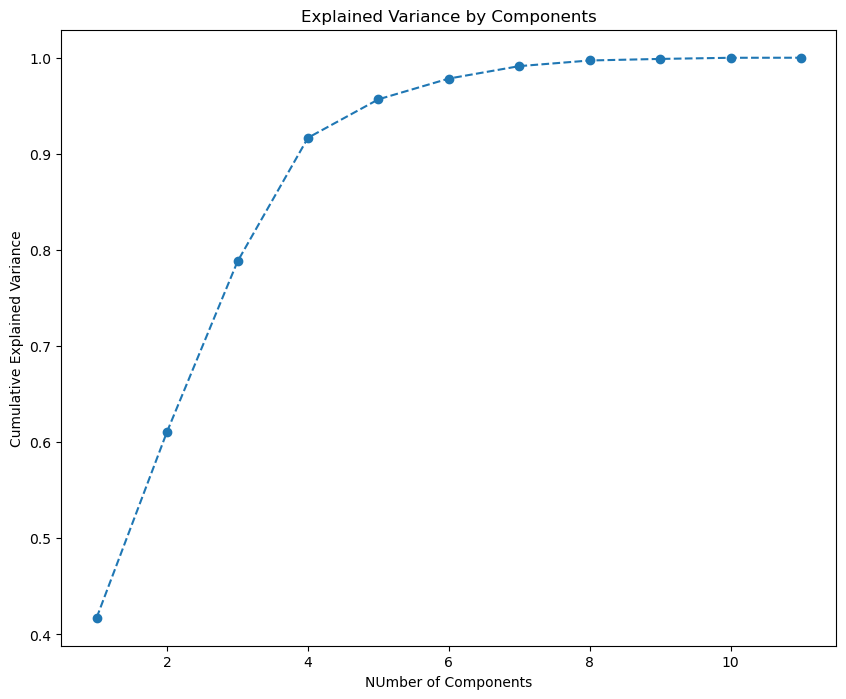

In [18]:
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize= (10, 8))
plt.plot(range(1,12), cumulative_explained_variance, marker = 'o', linestyle='--')
plt.title('Explained Variance by Components')
plt.xlabel('NUmber of Components')
plt.ylabel('Cumulative Explained Variance')

# Find the number of components that explain at least 80% of the variance
n_components_80 = np.argmax(cumulative_explained_variance >= 0.80) + 1
print(f"Number of components explaining at least 80% variance: {n_components_80}")

In [19]:
pca = PCA(n_components=4)
features_pca = pca.fit_transform(embeddings)

## Determine the number of clusters(k)

In [20]:
# Define a range of k values to test
k_range = range(1, 20)

wcss = []
for k in k_range:
    print('Now on k {}'.format(k))
    kmeans = KMeans(n_clusters=k, random_state=0).fit(features_pca)
    wcss.append(kmeans.inertia_)

Now on k 1
Now on k 2
Now on k 3
Now on k 4
Now on k 5
Now on k 6
Now on k 7
Now on k 8
Now on k 9
Now on k 10
Now on k 11
Now on k 12
Now on k 13
Now on k 14
Now on k 15
Now on k 16
Now on k 17
Now on k 18
Now on k 19


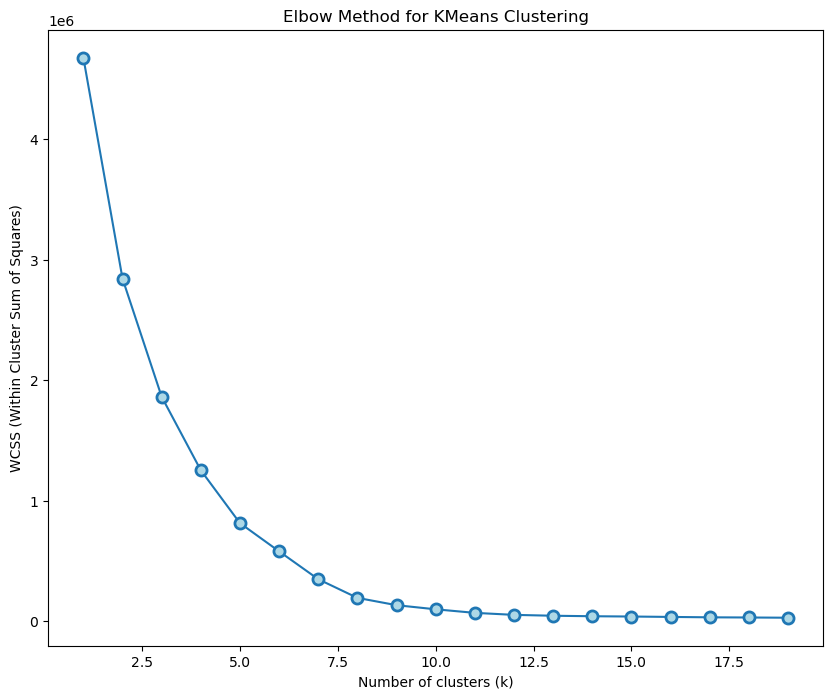

In [21]:
# Plotting WCSS vs k to identify the elbow point
plt.figure(figsize=(10, 8))
plt.plot(k_range, wcss, 'o-', markerfacecolor='lightblue', markeredgewidth=2, markersize=8)
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (Within Cluster Sum of Squares)')
plt.title('Elbow Method for KMeans Clustering')
plt.show()

## Clustering

In [22]:
# Fit the KMeans model
kmeans = KMeans(n_clusters=4, random_state=0).fit(features_pca)

# Get the cluster labels
cluster_labels = kmeans.labels_

# Get the cluster centers
cluster_centers = kmeans.cluster_centers_

df_pca = pd.concat([df.reset_index(drop=True), pd.DataFrame(features_pca)], axis=1)
df_pca.columns.values[-4: ] = ['Component 1', 'Component 2', 'Component 3', 'Component 4']
df_pca['clusters'] = kmeans.labels_
df_pca['cluster_kmeans'] = kmeans.predict(features_pca)
df_latex = df_pca.groupby(['cluster_kmeans']).mean()
df_latex

,yeojohnson_revenue_in_eur_bin,is_EMEA,is_Webshop,is_industry_FinanceInsuranceRealEstate,is_industry_Manufacturing,is_industry_Other,is_industry_RetailTrade,is_industry_Services,is_industry_WholesaleTrade,license_value_score,customer_value_score,Component 1,Component 2,Component 3,Component 4,clusters
cluster_kmeans,,,,,,,,,,,,,,,,
0,0.485432,1.000000,0.478388,0.272171,0.000000,0.0,0.358437,0.000000,0.369392,0.450024,0.413505,0.495206,-0.985352,5.007490,-0.831847,0.0
1,0.544663,0.745834,0.492900,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.437531,0.376845,9.612656,-1.328754,-2.428840,0.746498,1.0
2,0.676805,0.000000,0.531420,0.078562,0.179507,0.0,0.094088,0.557281,0.090562,0.425690,0.339433,-0.644868,5.273736,-0.442306,-0.134492,2.0
3,0.405813,1.000000,0.473977,0.000000,0.234338,0.0,0.000000,0.765662,0.000000,0.466858,0.440621,-3.454091,-1.552406,-1.496279,0.223790,3.0


In [23]:
df_latex.drop(columns=['Component 1', 'Component 2', 'Component 3', 'Component 4', 'clusters'], inplace=True)
df_latex = df_latex.T

In [24]:
df_latex

cluster_kmeans,0,1,2,3
yeojohnson_revenue_in_eur_bin,0.485432,0.544663,0.676805,0.405813
is_EMEA,1.000000,0.745834,0.000000,1.000000
is_Webshop,0.478388,0.492900,0.531420,0.473977
is_industry_FinanceInsuranceRealEstate,0.272171,0.000000,0.078562,0.000000
is_industry_Manufacturing,0.000000,0.000000,0.179507,0.234338
is_industry_Other,0.000000,1.000000,0.000000,0.000000
is_industry_RetailTrade,0.358437,0.000000,0.094088,0.000000
is_industry_Services,0.000000,0.000000,0.557281,0.765662
is_industry_WholesaleTrade,0.369392,0.000000,0.090562,0.000000
license_value_score,0.450024,0.437531,0.425690,0.466858


In [25]:
latex_table = df_latex.to_latex(
    index=False,  # To not include the DataFrame index as a column in the table
    caption="Average Values of each feature per Cluster",  # The caption to appear above the table in the LaTeX document
    label="tab:avg_clusters",  # A label used for referencing the table within the LaTeX document
    position="H",  # The preferred positions where the table should be placed in the document ('here', 'top', 'bottom', 'page')
    column_format="cccc",  # The format of the columns: left-aligned with vertical lines between them
    escape=False,  # Disable escaping LaTeX special characters in the DataFrame
    float_format="{:0.3f}".format  # Formats floats to two decimal places
)

print(latex_table)

\begin{table}[H]
\centering
\caption{Average Values of each feature per Cluster}
\label{tab:avg_clusters}
\begin{tabular}{cccc}
\toprule
    0 &     1 &     2 &     3 \\
\midrule
0.485 & 0.545 & 0.677 & 0.406 \\
1.000 & 0.746 & 0.000 & 1.000 \\
0.478 & 0.493 & 0.531 & 0.474 \\
0.272 & 0.000 & 0.079 & 0.000 \\
0.000 & 0.000 & 0.180 & 0.234 \\
0.000 & 1.000 & 0.000 & 0.000 \\
0.358 & 0.000 & 0.094 & 0.000 \\
0.000 & 0.000 & 0.557 & 0.766 \\
0.369 & 0.000 & 0.091 & 0.000 \\
0.450 & 0.438 & 0.426 & 0.467 \\
0.414 & 0.377 & 0.339 & 0.441 \\
\bottomrule
\end{tabular}
\end{table}



In [26]:
df_pca.cluster_kmeans.value_counts()

3    42251
0    21909
2    20417
1    15423
Name: cluster_kmeans, dtype: int64

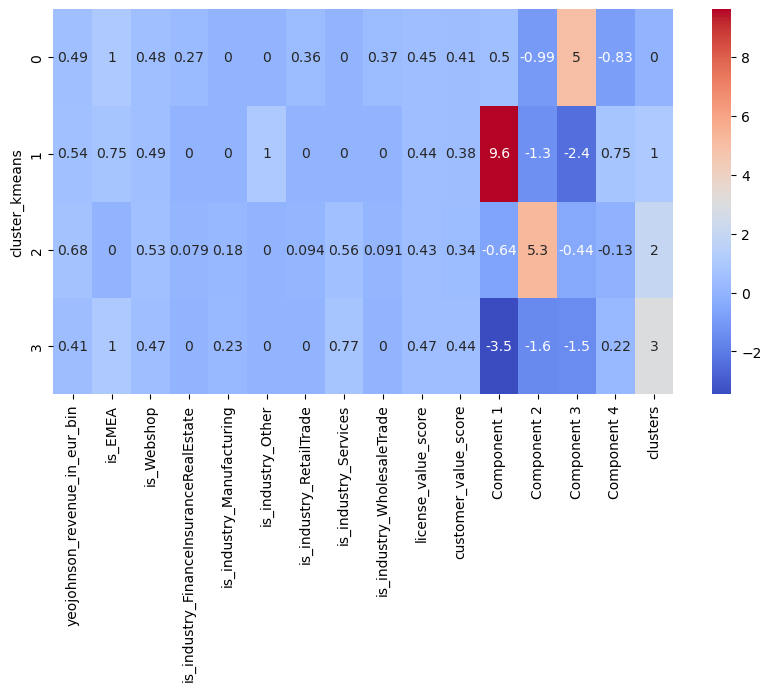

In [27]:
# Visualize the correlation matrix
plt.figure(figsize=(10,5))
sns.heatmap(df_pca.groupby(['cluster_kmeans']).mean(), cmap='coolwarm', annot=True)
plt.show()

In [28]:
clusters=pd.DataFrame(features, columns=features_df.columns)
clusters['label']=kmeans.labels_
polar=clusters.groupby("label").mean().reset_index()
polar=pd.melt(polar,id_vars=["label"])
fig = px.line_polar(polar, r="value", theta="variable", color="label", 
                    line_close=True,
                    height=800,
                    width=1200, 
                    title="DEC Model 10-Feature Set Radar Chart")
fig.show()

In [29]:
clusters_df = clusters.groupby('label').size().reset_index()
clusters_df.rename(columns={'label': 'cluster', 0: 'count'}, inplace=True)
clusters_df

,cluster,count
0,0,21909
1,1,15423
2,2,20417
3,3,42251


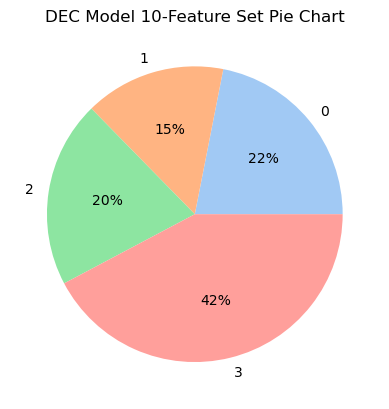

In [30]:
#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]

#create pie chart
plt.pie(clusters_df['count'], labels = clusters_df['cluster'], colors = colors, autopct='%.0f%%')
plt.title('DEC Model 10-Feature Set Pie Chart')
plt.show()

## Evaluation

In [31]:
# Calculate Silhouette Score
silhouette_avg = silhouette_score(features_pca, cluster_labels)
print(f'Silhouette Score: {silhouette_avg:.3f}')

Silhouette Score: 0.571


In [32]:
# Calculate Davies-Bouldin Index
davies_bouldin_avg = davies_bouldin_score(features_pca, cluster_labels)
print(f'Davies-Bouldin Index: {davies_bouldin_avg:.3f}')

Davies-Bouldin Index: 0.786
